# WT: early (day 3-5) vs. late phase (day 9-14)

In [1]:
library(sleuth)
library(splines)
library(scales)
library(ggplot2)

In [2]:
#https://stackoverflow.com/questions/41849951/using-ggplot-geo-geom-histogram-with-y-log-scale-with-zero-bins
mylog10_trans <- function (base = 10) 
{
  trans <- function(x) log(x + 1, base)
  inv <- function(x) base^x
  trans_new(paste0("log-", format(base)), trans, inv, log_breaks(base = base), 
            domain = c(1e-100, Inf))
}

In [3]:
d=read.delim("../kallisto/sample_descriptions/our_data.txt",sep="\t",stringsAsFactors=FALSE)
names(d)[1:2]=c("sample","sample_alias")
d$batch=as.numeric(gsub("^[^-]+-[^-]+-[^-]+-(\\d+$)$","\\1",gsub("([A-z]+)(\\d+)","\\1-\\2",d$sample,perl=TRUE),perl=TRUE))
d$batch[is.na(d$batch)]=1
table(d$batch)
d$harvest=sprintf("%id_b%i",d$Time,d$batch)
d$phase=factor(ifelse(d$Time<9, "early","late"),levels=c("early","late"))
table(d$harvest)
head(d)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”



 1  2  3 
24 25 25 


12d_b1 12d_b2 12d_b3 14d_b1 14d_b2 14d_b3  3d_b1  3d_b2  3d_b3  5d_b1  5d_b2 
     5      5      5      5      5      5      4      5      5      5      5 
 5d_b3  9d_b1  9d_b2  9d_b3 
     5      5      5      5 

,sample,sample_alias,Group,GT,Time,elongation_caulonema,protonemata_branching,number_buds_per_filament,percents_filaments_with_buds,gametophore_formation,colony_size,rhizoid_formation,development_of_phyllids,batch,harvest,phase
,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<fct>
1,1-W3,1.W3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1,early
2,2-W3-2,2.W3.2,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2,early
3,3-W3-3,3.W3.3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3,early
4,4-D3,4.D3,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1,early
5,5-D3-2,5.D3.2,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2,early
6,6-D3-3,6.D3.3,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3,early


In [4]:
#outlier replicates
exclude=d$sample[grep("5-3$",d$sample,perl=TRUE)]

In [5]:
d=subset(d,! sample %in% exclude )

In [6]:
table(d$GT,d$Time)
table(d$GT,d$phase)

          
           3 5 9 12 14
  deltaDEK 3 2 3  3  3
  LG3      3 2 3  3  3
  Loop     3 2 3  3  3
  OE       2 2 3  3  3
  WT       3 2 3  3  3

          
           early late
  deltaDEK     5    9
  LG3          5    9
  Loop         5    9
  OE           4    9
  WT           5    9

In [7]:
table(file.exists(sprintf("../kallisto/kallisto/%s/abundance.h5",d$sample)))


TRUE 
  69 

In [8]:
d$path=sprintf("../kallisto/kallisto/%s/abundance.h5",d$sample)

In [9]:
m=read.delim("../analysis/cosmoss_V3.3.mRNA_ncRNA.tx2gene.full.tsv",stringsAsFactors=FALSE)
names(m)[1]="target_id"
m$class=ifelse(is.na(m$class),m$TYPE,m$class)
m$gene=paste(m$GENEID,m$class,sep=".")
m=m[,c("target_id","gene","class","TYPE")]
nrow(m)
head(m)

[1] 93962

,target_id,gene,class,TYPE
,<chr>,<chr>,<chr>,<chr>
1,Pp3c1_20V3.1,Pp3c1_20.mRNA,mRNA,mRNA
2,Pp3c1_20V3.2,Pp3c1_20.mRNA,mRNA,mRNA
3,Pp3c1_40V3.2,Pp3c1_40.mRNA,mRNA,mRNA
4,Pp3c1_40V3.1,Pp3c1_40.mRNA,mRNA,mRNA
5,Pp3c1_50V3.2,Pp3c1_50.mRNA,mRNA,mRNA
6,Pp3c1_50V3.1,Pp3c1_50.mRNA,mRNA,mRNA


In [10]:
D=droplevels(subset(d, GT %in% c("WT")))
head(D)
table(D$GT,D$Time)
table(D$Time,D$phase)

,sample,sample_alias,Group,GT,Time,elongation_caulonema,protonemata_branching,number_buds_per_filament,percents_filaments_with_buds,gametophore_formation,colony_size,rhizoid_formation,development_of_phyllids,batch,harvest,phase,path
,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<fct>,<chr>
1,1-W3,1.W3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1,early,../kallisto/kallisto/1-W3/abundance.h5
2,2-W3-2,2.W3.2,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2,early,../kallisto/kallisto/2-W3-2/abundance.h5
3,3-W3-3,3.W3.3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3,early,../kallisto/kallisto/3-W3-3/abundance.h5
15,15-W5,15.W5,6,WT,5,normal,normal,absent,absent,absent,normal,absent,absent,1,5d_b1,early,../kallisto/kallisto/15-W5/abundance.h5
16,16-W5-2,16.W5.2,6,WT,5,normal,normal,absent,absent,absent,normal,absent,absent,2,5d_b2,early,../kallisto/kallisto/16-W5-2/abundance.h5
30,30-W9,30.W9,11,WT,9,normal,normal,normal,normal,absent,normal,absent,absent,1,9d_b1,late,../kallisto/kallisto/30-W9/abundance.h5


    
     3 5 9 12 14
  WT 3 2 3  3  3

    
     early late
  3      3    0
  5      2    0
  9      0    3
  12     0    3
  14     0    3

In [11]:
so=sleuth_prep(D, target_mapping = m,aggregation_column = 'gene', 
               gene_mode = TRUE,extra_bootstrap_summary = TRUE,read_bootstrap_tpm=TRUE, num_cores=10)

'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.

reading in kallisto results

dropping unused factor levels

.
.
.
.
.
.
.
.
.
.
.
.
.
.


normalizing est_counts

44905 targets passed the filter

normalizing tpm

merging in metadata

aggregating by column: gene

Warning message:
“`select_()` is deprecated as of dplyr 0.7.0.
Please use `select()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
21752 genes passed the filter

Warning message in sleuth_prep(D, target_mapping = m, aggregation_column = "gene", :
“2 target_ids are missing annotations for the aggregation_column: gene.
These target_ids will be dropped from the gene-level analysis.
If you did not expect this, check your 'target_mapping' table for missing values.”
summarizing bootstraps





In [13]:
options(repr.plot.width=12, repr.plot.height=10)


In [14]:
table(D$phase)


early  late 
    5     9 

In [26]:
full_design2 <- model.matrix(formula(~ phase ),data=D)
reduced_design2 <- model.matrix(formula(~ 1),data=D)

In [27]:
full_design2
so.D=so

,(Intercept),phaselate
1,1,0
2,1,0
3,1,0
15,1,0
16,1,0
30,1,1
31,1,1
32,1,1
45,1,1
46,1,1


In [28]:
so.D= sleuth_fit(so.D,reduced_design2,fit_name="reduced2")

fitting measurement error models

shrinkage estimation

1 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Pp3c13_15980.mRNA

computing variance of betas



In [29]:
so.D= sleuth_fit(so.D, full_design2, fit_name = "full2")

fitting measurement error models

shrinkage estimation

1 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: Pp3c13_15980.mRNA

computing variance of betas



In [30]:
so.D = sleuth_lrt(so.D, "reduced2", "full2")

In [31]:
models(so.D)

[  reduced2  ]
formula:  structure(c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), .Dim = c(14L,  1L), .Dimnames = list(c("1", "2", "3", "15", "16", "30", "31",  "32", "45", "46", "47", "60", "61", "62"), "(Intercept)"), assign = 0L) 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
[  full2  ]
formula:  structure(c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,  0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1), .Dim = c(14L, 2L), .Dimnames = list(     c("1", "2", "3", "15", "16", "30", "31", "32", "45", "46",      "47", "60", "61", "62"), c("(Intercept)", "phaselate")), assign = 0:1, contrasts = list(     phase = "contr.treatment")) 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	phaselate


In [32]:
so.D = sleuth_wt(so.D, 'phaselate', which_model = "full2")

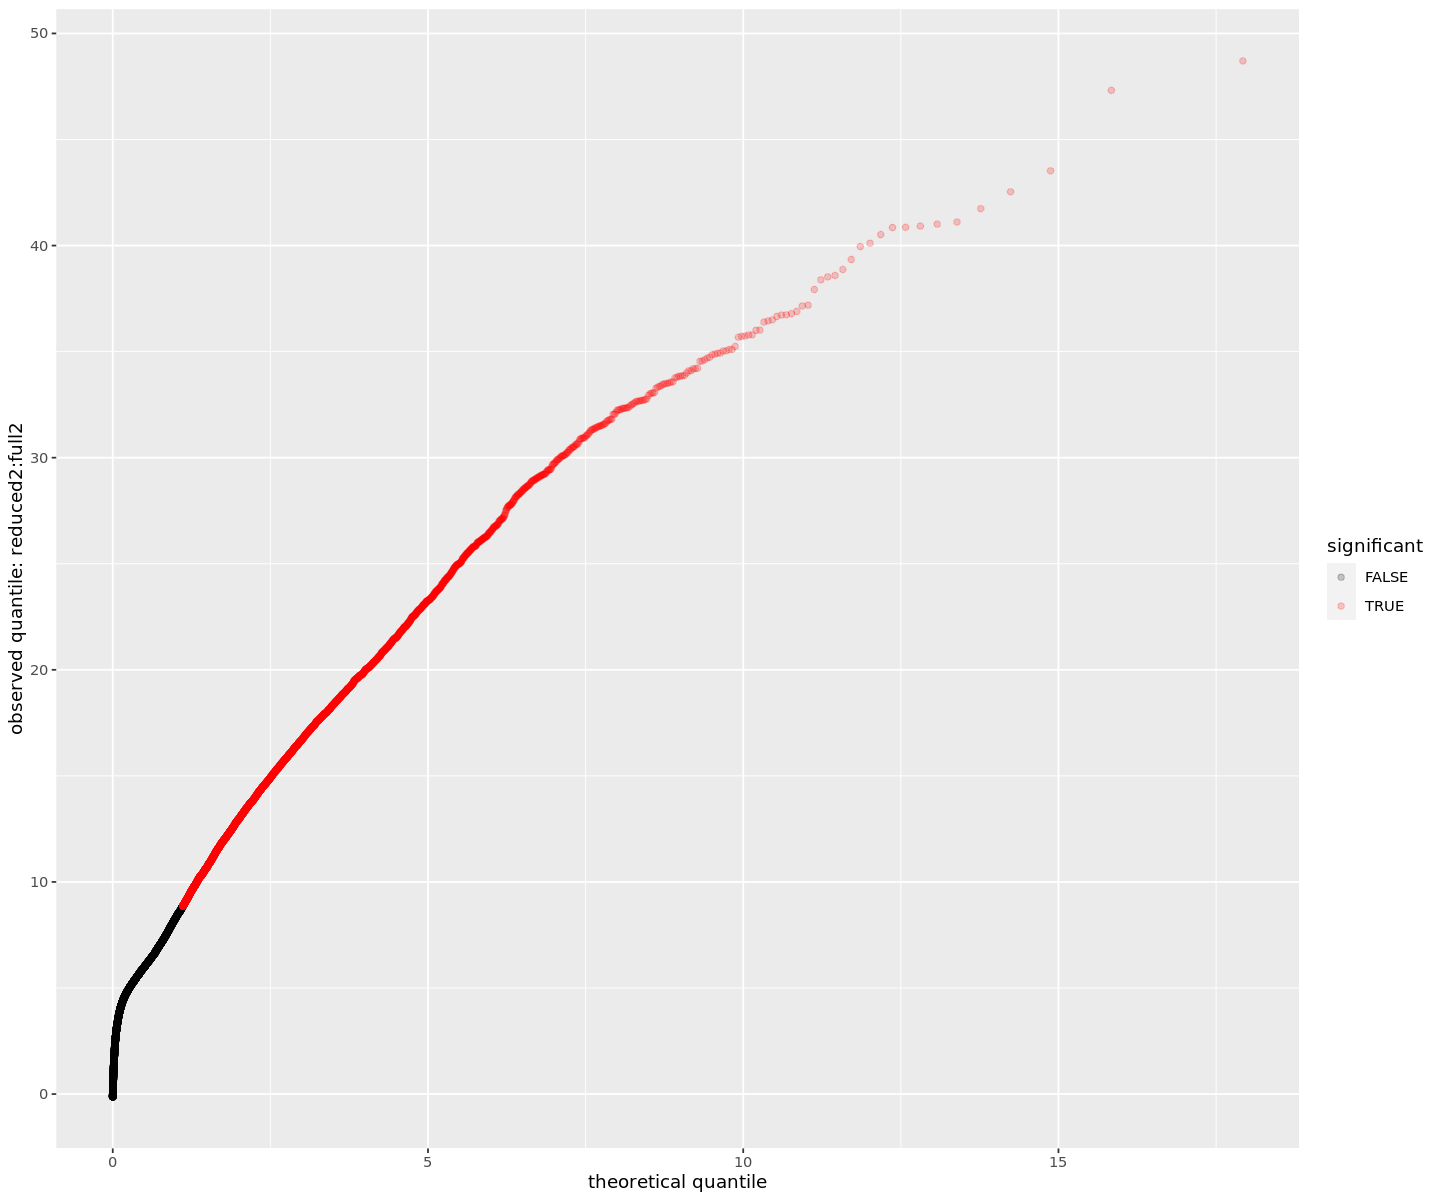

In [34]:
plot_qq(so.D, test = 'reduced2:full2', test_type = 'lrt', sig_level = 0.01)

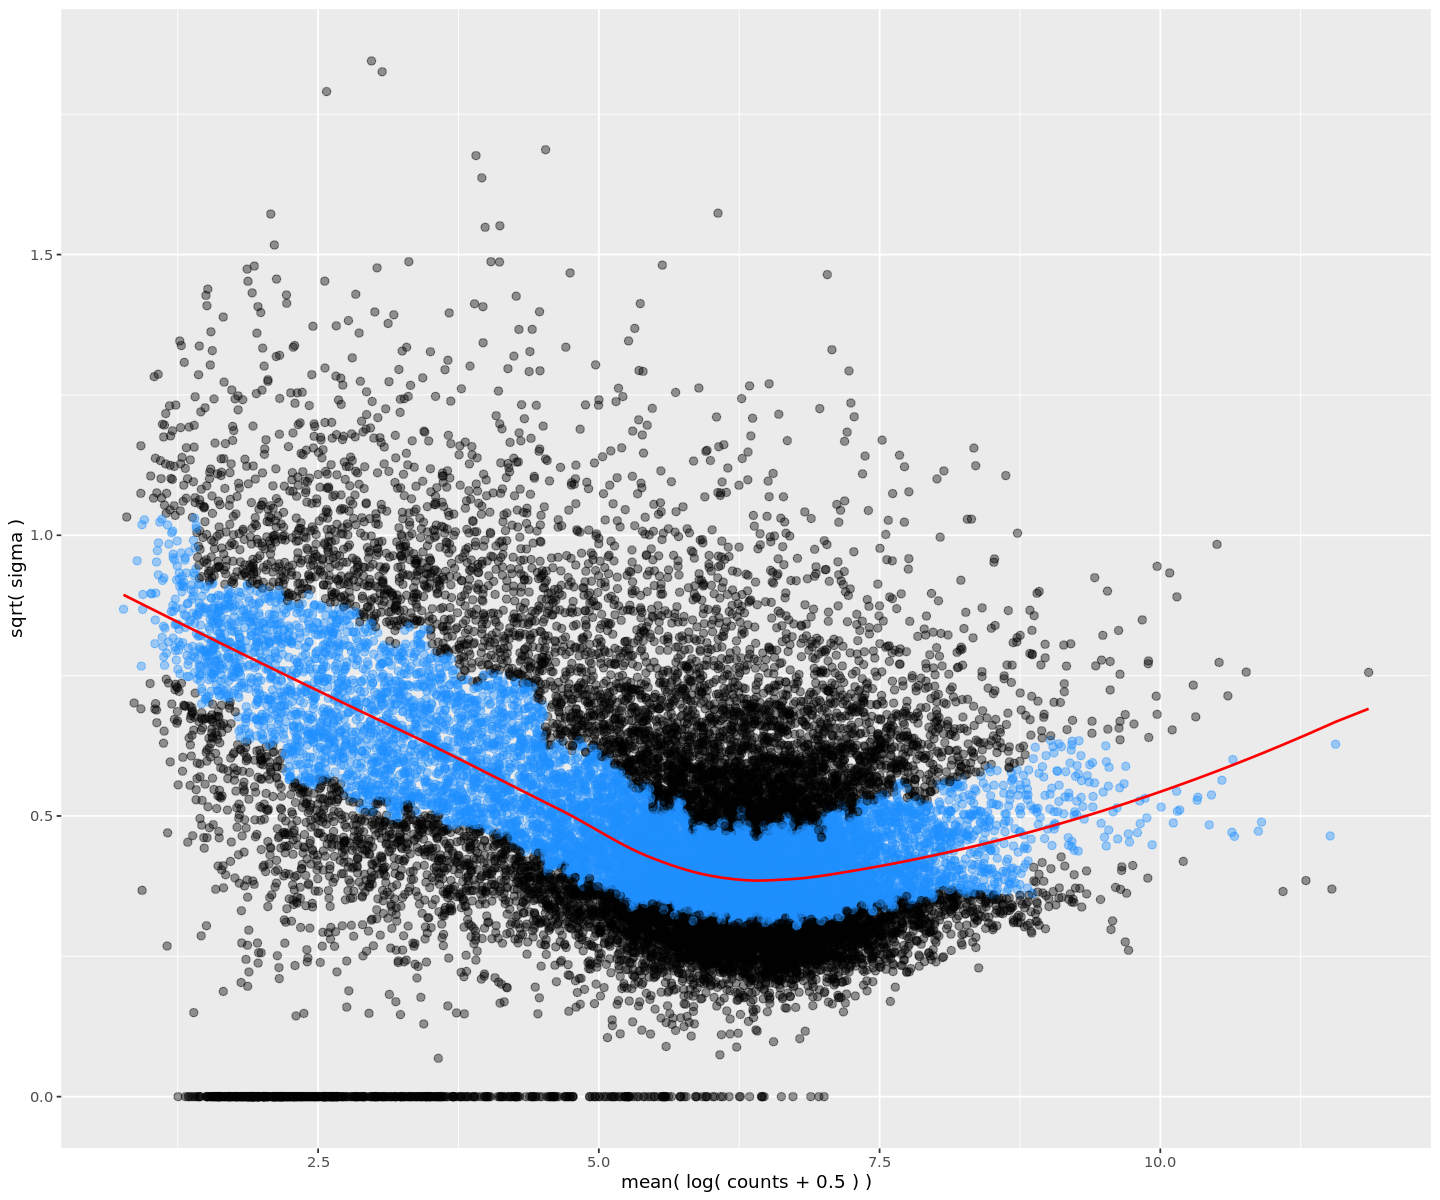

In [35]:
plot_mean_var(so.D,which_model="full2")

In [36]:
tt=sleuth_results(so.D,'phaselate','wt',which_model="full2" ,show_all = FALSE,rename_cols=FALSE)
tt.sig= dplyr::filter(tt, qval < 0.05)
nrow(tt.sig)
table(tt.sig$b>0)

[1] 8965


FALSE  TRUE 
 4098  4867 

In [37]:
lrt_results= sleuth_results(so.D, 'reduced2:full2', test_type = 'lrt',show_all=TRUE)

In [38]:
o=na.omit(merge(lrt_results,tt,by="target_id",suffixes=c(".lrt",".wt")))
o=o[order(-o$b,-o$test_stat),]
table(o$b>0)
head(o[o$b>0,])


FALSE  TRUE 
10035 11717 

,target_id,class.lrt,TYPE.lrt,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,var_obs.lrt,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
21613,Pp3s49_30.mRNA,mRNA,mRNA,2.977600e-12,6.476875e-08,48.70333,177.5279,1,4.010792,13.65600,⋯,1.008618e-84,2.193946e-80,7.317238,0.3751596,4.010792,13.65600,0.006823643,0.4455701,0.10997257,0.4455701
19790,Pp3c7_9420.mRNA,mRNA,mRNA,2.320054e-08,3.881986e-06,31.20635,186.8794,1,4.540091,14.37534,⋯,1.211662e-23,2.214796e-21,7.206672,0.7190361,4.540091,14.37534,0.012675319,1.6491517,0.07447159,1.6491517
14362,Pp3c26_14380.mRNA,mRNA,mRNA,2.602332e-10,4.354302e-07,39.95236,149.8390,1,3.568815,11.52608,⋯,5.613964e-45,1.110136e-41,6.629719,0.4711154,3.568815,11.52608,0.002858010,0.7105517,0.14794491,0.7105517
4910,Pp3c14_20550.mRNA,mRNA,mRNA,4.388513e-08,5.648458e-06,29.96970,145.4578,1,4.125416,11.18906,⋯,1.475792e-21,2.018958e-19,6.322859,0.6630092,4.125416,11.18906,0.079183880,1.3337556,0.10136846,1.3337556
6833,Pp3c16_3130.mRNA,mRNA,mRNA,1.112431e-07,9.757097e-06,28.16774,146.2688,1,3.651705,11.25145,⋯,7.944066e-19,7.480490e-17,6.282743,0.7090490,3.651705,11.25145,0.070836783,1.5451467,0.14025237,1.5451467
18227,Pp3c6_15620.mRNA,mRNA,mRNA,2.525141e-08,4.099020e-06,31.04193,136.7621,1,5.413097,10.52016,⋯,2.351254e-23,4.124554e-21,6.160701,0.6187327,5.413097,10.52016,0.095882724,1.1346428,0.03419986,1.1346428


In [39]:
m1=read.delim("../analysis//cosmoss_V3.3.mRNA_ncRNA.tx2gene.full.gene_wise.tsv",sep="\t",stringsAsFactors=FALSE)
names(m1)[1]="target_id"
head(m1)

,target_id,spectype,TXNAME,GENEID,TYPE,Alias,support,origin,isoform,longest_transcript,has_evidence,class,has_protein_homology,has_proteomics_support,encoded_by,is_filtered
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Pp3c10_10000.tRNA,tRNA,Pp3c10_10000V3.1,Pp3c10_10000,ncRNA,"tRNA,Pp3c10_10000N1.1,Pp3c10_10000V1.1,N1.Chr10.ncRNA.54,tRNA.717",supported_by_sequence_similarity,RFAM11.Infernal1.1,major,true,false,tRNA,false,false,ncRNA_gene,false
2,Pp3c10_10040.mRNA,mRNA,"Pp3c10_10040V3.2,Pp3c10_10040V3.3,Pp3c10_10040V3.5,Pp3c10_10040V3.6,Pp3c10_10040V3.4,Pp3c10_10040V3.1",Pp3c10_10040,mRNA,"PAC4GC:5701563,Pp3c10_10040J4.1,Pp1s58_283V6.2,PAC4GC:5701564,P2.evm.model.Chr10.357,Pp3c10_10040J5.3,Pp3c10_10040J5.4,Pp3c10_10040V1.1,P2.Chr10.mRNA.3452,Phpatv32029367m,PAC4GC:5701565,Phpatv32029366m,PAC4GC:5701561,Pp3c10_10040J5.2,Pp1s58_283V6.1,Pp3c10_10040J5.1,Phpatv32029364m,Pp3c10_10040P2.1,Phpatv32029365m,Phpatv32029363m,P2.EVM%20prediction%20Chr10.357,Pp3c10_10040P2.2,PAC4GC:5701562",supported_by_EST_or_cDNA,NA,"alternative,major","true,false",true,NA,true,false,protein_coding_gene,false
3,Pp3c10_10090.mRNA,mRNA,"Pp3c10_10090V3.2,Pp3c10_10090V3.1",Pp3c10_10090,mRNA,"Phpatv32029368m,Pp3c10_10090V1.1,J3.Chr10.mRNA.912,J3.Phypav3.0.4_pg25522.valid.m1,J3.7022241,Pp3c10_10090J4.1,Pp3c10_10090J3.1,PAC4GC:5700224,pred.234120000946",supported_by_EST_or_cDNA,NA,"major,alternative","false,true",true,NA,false,false,protein_coding_gene,false
4,Pp3c10_10095.C_D_box_snoRNA,C_D_box_snoRNA,Pp3c10_10095V3.1,Pp3c10_10095,ncRNA,"Chr10.snoRNA.21,snoR64.1,Chr10.snoRNA.22,Pp3c10_10095V1.1,Chr10.snoRNA.32,Chr10.snoRNA.23,snoR64,N1.Chr10.ncRNA.55,Pp3c10_10095N1.1,Chr10.snoRNA.33,snR72%2FZ2,snR58",supported_by_sequence_similarity,"RFAM11.Infernal1.1,snoscan-0.9b",major,true,true,C_D_box_snoRNA,false,false,ncRNA_gene,false
5,Pp3c10_100.ncRNA,ncRNA,Pp3c10_100V3.1,Pp3c10_100,ncRNA,"Pp3c10_100V1.1,Pp3c10_100P0.1,asmbl_110854",supported_by_EST_or_cDNA,NA,major,true,true,NA,false,false,ncRNA_gene,false
6,Pp3c10_10100.mRNA,mRNA,"Pp3c10_10100V3.1,Pp3c10_10100V3.4,Pp3c10_10100V3.2,Pp3c10_10100V3.5,Pp3c10_10100V3.3",Pp3c10_10100,mRNA,"Pp3c10_10100J5.3,Phpatv32029369m,PAC4GC:5701591,PAC4GC:5701593,Pp1s58_289V6.1_29440,PAC4GC:5701592,Phpatv32029370m,Pp3c10_10100V1.1,Phpatv32029372m,Pp3c10_10100J5.1,Pp3c10_10100J5.2,C1.Pp1s58_289V6.1,Phpatv32029371m,C1.560145,PAC4GC:5701590,Pp1s58_289V6.1,C1.Chr10.mRNA.576,Pp3c10_10100J4.1,Pp3c10_10100C1.1",supported_by_EST_or_cDNA,NA,"alternative,major","true,false",true,NA,true,false,protein_coding_gene,false


In [40]:
m2=read.delim("../analysis//cosmoss.genonaut.V3.3.gene_and_protein_names.tsv",sep="\t",col.names=c("GENEID","name"),stringsAsFactors=FALSE)
head(m2)

,GENEID,name
,<chr>,<chr>
1,Pp3c10_13310,XTH28
2,Pp3c10_13800,"chr1545,CHR1545"
3,Pp3c10_13960,"CHLH1,CHLH2,chlh2,chlh1"
4,Pp3c10_13970,"chlh1,chlh2,CHLH2,CHLH1"
5,Pp3c10_14020,"RABA53,raba53"
6,Pp3c10_14800,"PPR_20,ppr_20"


In [41]:
m3=read.delim("../analysis//Ppatens_318_v3.3.defline.txt",sep="\t",col.names=c("GENEID","source","defline"),stringsAsFactors=FALSE)
m3$GENEID=gsub("V3\\.\\d+","",m3$GENEID,perl=TRUE)
head(m3)

,GENEID,source,defline
,<chr>,<chr>,<chr>
1,Pp3c10_10220,pdef,"K00615 - transketolase (E2.2.1.1, tktA, tktB) (1 of 4)"
2,Pp3c10_10230,pdef,K14763 - H/ACA ribonucleoprotein complex non-core subunit NAF1 (NAF1) (1 of 1)
3,Pp3c10_10240,pdef,PTHR10641:SF599 - MYB TRANSCRIPTION FACTOR-RELATED (1 of 3)
4,Pp3c10_10270,pdef,2.4.1.12 - Cellulose synthase (UDP-forming) / UDP-glucose-cellulose glucosyltransferase (1 of 17)
5,Pp3c10_10460,pdef,"K03320 - ammonium transporter, Amt family (amt, AMT, MEP) (1 of 12)"
6,Pp3c10_10490,pdef,"PTHR11177:SF167 - RHODANESE-LIKE DOMAIN-CONTAINING PROTEIN 4, CHLOROPLASTIC (1 of 3)"


In [42]:
m4=read.delim("../analysis//Physcomitrella_patens.TAP_annotation.6.tsv",sep="\t")
names(m4)[2]="GENEID"
head(m4)

,superfamily,GENEID,inferred_by_rule,TAP_class
,<chr>,<chr>,<chr>,<chr>
1,BSD domain containing,Pp3c11_12590V3,True,PT
2,BSD domain containing,Pp3c1_21290V3,True,PT
3,BSD domain containing,Pp3c20_12230V3,True,PT
4,BSD domain containing,Pp3c23_10600V3,True,PT
5,BSD domain containing,Pp3c24_7080V3,True,PT
6,BSD domain containing,Pp3c26_14480V3,True,PT


In [43]:
O=merge(o,m1,by="target_id")
nrow(o)
nrow(O)
O=merge(O,m2,by="GENEID",all.x=TRUE)
nrow(O)
O=merge(O,m3,by="GENEID",all.x=TRUE)
nrow(O)
O=merge(O,m4,by="GENEID",all.x=TRUE)
nrow(O)
O=O[order(-O$test_stat),]
head(O)

[1] 21752

[1] 21752

[1] 21752

[1] 21752

[1] 21752

,GENEID,target_id,class.lrt,TYPE.lrt,pval.lrt,qval.lrt,test_stat,rss,degrees_free,mean_obs.lrt,⋯,has_protein_homology,has_proteomics_support,encoded_by,is_filtered,name,source,defline,superfamily,inferred_by_rule,TAP_class
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
21613,Pp3s49_30,Pp3s49_30.mRNA,mRNA,mRNA,2.977600e-12,6.476875e-08,48.70333,177.52794,1,4.010792,⋯,true,true,protein_coding_gene,false,NA,pdef,PF06830 - Root cap (Root_cap) (1 of 7),NA,NA,NA
13307,Pp3c24_1600,Pp3c24_1600.mRNA,mRNA,mRNA,6.038035e-12,6.566966e-08,47.31719,123.04622,1,3.224656,⋯,true,true,protein_coding_gene,false,"CALS3,cals3",pdef,"2.4.1.34 - 1,3-beta-glucan synthase / UDP-glucose-1,3-beta-D-glucan glucosyltransferase (1 of 20)",NA,NA,NA
16687,Pp3c4_23600,Pp3c4_23600.mRNA,mRNA,mRNA,4.190429e-11,3.038340e-07,43.52283,101.86262,1,2.844762,⋯,true,false,protein_coding_gene,false,NA,pdef,PF00612//PF13178 - IQ calmodulin-binding motif (IQ) // Protein of unknown function (DUF4005) (DUF4005) (1 of 10),NA,NA,NA
21309,Pp3c9_7900,Pp3c9_7900.mRNA,mRNA,mRNA,6.948033e-11,3.577945e-07,42.53355,61.20326,1,2.266675,⋯,true,false,protein_coding_gene,false,NA,pdef,"PF03763 - Remorin, C-terminal region (Remorin_C) (1 of 17)",NA,NA,NA
9936,Pp3c2_30710,Pp3c2_30710.mRNA,mRNA,mRNA,1.042999e-10,3.577945e-07,41.73914,72.46078,1,2.475842,⋯,true,false,protein_coding_gene,false,NA,pdef,PTHR10334:SF204 - ALLERGEN V5/TPX-1-RELATED FAMILY PROTEIN-RELATED (1 of 3),NA,NA,NA
1484,Pp3c10_12410,Pp3c10_12410.mRNA,mRNA,mRNA,1.439139e-10,3.577945e-07,41.10979,61.41560,1,2.288636,⋯,true,false,protein_coding_gene,false,NA,pdef,PTHR10641:SF653 - ATMYB103 (1 of 4),NA,NA,NA


In [44]:
t(O[ O$target_id=='Pp3c17_17550.mRNA',])

,7369
GENEID,Pp3c17_17550
target_id,Pp3c17_17550.mRNA
class.lrt,mRNA
TYPE.lrt,mRNA
pval.lrt,0.002732048
qval.lrt,0.009534507
test_stat,8.9783
rss,0.4622573
degrees_free,1
mean_obs.lrt,7.321994


In [45]:
table(o$qval.lrt<0.05)
table(o$qval.wt<0.05)
table(o$qval.lrt<0.05,o$qval.wt<0.05)


FALSE  TRUE 
 7070 14682 


FALSE  TRUE 
12787  8965 

       
        FALSE TRUE
  FALSE  7070    0
  TRUE   5717 8965

In [46]:
head(O[,c("target_id","test_stat","b","qval.lrt","qval.wt","name","superfamily","TAP_class","defline")],n=50)

,target_id,test_stat,b,qval.lrt,qval.wt,name,superfamily,TAP_class,defline
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
21613,Pp3s49_30.mRNA,48.70333,7.317238,6.476875e-08,2.193946e-80,NA,NA,NA,PF06830 - Root cap (Root_cap) (1 of 7)
13307,Pp3c24_1600.mRNA,47.31719,6.094313,6.566966e-08,4.824718e-54,"CALS3,cals3",NA,NA,"2.4.1.34 - 1,3-beta-glucan synthase / UDP-glucose-1,3-beta-D-glucan glucosyltransferase (1 of 20)"
16687,Pp3c4_23600.mRNA,43.52283,5.503414,3.038340e-07,3.010300e-54,NA,NA,NA,PF00612//PF13178 - IQ calmodulin-binding motif (IQ) // Protein of unknown function (DUF4005) (DUF4005) (1 of 10)
21309,Pp3c9_7900.mRNA,42.53355,4.279663,3.577945e-07,1.887683e-34,NA,NA,NA,"PF03763 - Remorin, C-terminal region (Remorin_C) (1 of 17)"
9936,Pp3c2_30710.mRNA,41.73914,4.628338,3.577945e-07,5.095556e-45,NA,NA,NA,PTHR10334:SF204 - ALLERGEN V5/TPX-1-RELATED FAMILY PROTEIN-RELATED (1 of 3)
1484,Pp3c10_12410.mRNA,41.10979,4.268938,3.577945e-07,6.029607e-34,NA,NA,NA,PTHR10641:SF653 - ATMYB103 (1 of 4)
5783,Pp3c15_21000.mRNA,41.00961,4.481538,3.577945e-07,6.208948e-45,NA,NA,NA,NA
18149,Pp3c6_12850.mRNA,40.91753,3.821957,3.577945e-07,1.090820e-44,NA,NA,NA,PTHR22814:SF105 - HEAVY METAL TRANSPORT/DETOXIFICATION DOMAIN-CONTAINING PROTEIN (1 of 59)
20520,Pp3c8_7390.mRNA,40.86070,4.842006,3.577945e-07,1.424965e-44,NA,NA,NA,NA


In [47]:
plot_transcript_heatmap(so.D, head(O, n = 25)$target_id)

In [48]:
subset(O,spectype=="pre_miRNA" & qval.lrt<0.1)[,c("target_id","test_stat","b","qval.lrt","qval.wt","Alias")]

,target_id,test_stat,b,qval.lrt,qval.wt,Alias
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
7080,Pp3c16_9758.pre_miRNA,16.765171,-1.84614634,0.0005126283,1.545527e-06,"MI0003501,Pp3c16_9758N1.1,ppt-MIR534a,N1.Chr16.ncRNA.50,Pp3c16_9758V1.1"
20523,Pp3c8_7462.pre_miRNA,14.076130,-1.49155469,0.0013375585,1.219477e-04,"ppt-MIR1049,Pp3c8_7462V1.1,N1.Chr08.ncRNA.35,Pp3c8_7462N1.1,MI0006008"
18129,Pp3c6_12422.pre_miRNA,13.419740,-0.62206560,0.0016999481,3.173117e-04,"Pp3c6_12422N1.1,N1.Chr06.ncRNA.71,ppt-MIR419,Pp3c6_12422V1.1,MI0005670"
16902,Pp3c4_3072.pre_miRNA,11.021995,3.42885777,0.0042558184,6.881082e-04,"N1.Chr04.ncRNA.14,ppt-MIR1042,MI0006001,Pp3c4_3072V1.1,ppt-MIR1043,Pp3c4_3072V1.2,MI0006002,Pp3c4_3072N1.1,N1.Chr04.ncRNA.15,Pp3c4_3072N1.2"
7639,Pp3c17_2572.pre_miRNA,4.871525,-0.14682591,0.0436308241,8.066172e-01,"MI0006015,N1.Chr17.ncRNA.13,Pp3c17_2572V1.1,ppt-MIR1056,Pp3c17_2572N1.1"
12208,Pp3c22_2794.pre_miRNA,4.466520,-0.24496514,0.0507894518,3.871038e-01,"MI0003499,Pp3c22_2794N1.1,MIR159.3,ppt-MIR319d,Pp3c22_2794V1.1,N1.Chr22.ncRNA.13,MIR159"
9064,Pp3c19_7045.pre_miRNA,4.385410,0.07299489,0.0524731532,9.202103e-01,"Pp3c19_7045V1.1,MIR159.4,ppt-MIR319b,MIR159,Pp3c19_7045N1.1,N1.Chr19.ncRNA.58,MI0003497"


In [50]:
write.table(o,gzfile("comp.WT_phases/dge.tsv.gz"),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)
write.table(O,gzfile("comp.WT_phases/dge.full.tsv.gz"),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)